# 1. Introduction

## 1.1 Dataset Description and Source

### Origin and Creation Context

The data for this notebook originates from **EXIST 2025** (*sEXism Identification in Social neTworks*, fifth edition), a scientific shared task organized as a Lab within the **CLEF 2025 conference** (Conference and Labs of the Evaluation Forum), held on September 9–12, 2025, at UNED, Madrid, Spain. EXIST is a recurring series of evaluation campaigns, active since 2021, dedicated to fostering automatic detection of sexism in social media — ranging from explicit misogyny to subtle, implicit sexist behaviours.

The dataset used in this notebook corresponds specifically to **Task 1 (Sexism Detection in Tweets), Subtask 1.1 (Sexism Identification in Tweets)**, and consists of posts collected from **X/Twitter** in two languages: **English and Spanish**. The tweets were gathered using seed hashtags associated with potentially sexist content, and the collection strategy was designed to ensure broad topical and temporal coverage. The corpus contains **over 10,000 tweets** split into three official partitions:

| Split       | Size (posts) |
|-------------|-------------|
| Training    | 6,920        |
| Development | 1,038        |
| Test        | 2,076        |

**Annotation process.** Each tweet was independently labelled by **six human annotators** recruited and managed via Servipoli's annotation service at UPV (Universitat Politècnica de València). Annotators received task-specific training through multiple guided sessions before labelling began. Demographic metadata for annotators — including gender, age group, ethnicity, education level, and country of origin — is provided alongside the labels, enabling fairness-aware modelling and analysis of annotator subjectivity. Crucially, the dataset is released with **all individual annotations preserved** rather than a single adjudicated label, in keeping with the Learning with Disagreement (LeWiDi) paradigm adopted since EXIST 2023. This design choice reflects the organisers' position that inter-annotator disagreement on subjective tasks such as sexism identification is a meaningful signal, not noise to be discarded.

### Access

Access to all EXIST datasets (2021–2025) is granted for research purposes upon completing the official request form provided by the organisers:

> Request form: https://forms.office.com/e/ikGpvRQ1qv

### Full Academic Citations

**Primary task overview paper (LNCS proceedings):**

> Plaza, L., Carrillo-de-Albornoz, J., Arcos, I., Rosso, P., Spina, D., Amigó, E., Gonzalo, J., & Morante, R. (2025). Overview of EXIST 2025: Learning with Disagreement for Sexism Identification and Characterization in Tweets, Memes, and TikTok Videos. In J. Carrillo-De-Albornoz et al. (Eds.), *Experimental IR Meets Multilinguality, Multimodality, and Interaction. CLEF 2025*. Lecture Notes in Computer Science, vol. 16089. Springer, Cham. https://link.springer.com/book/10.1007/978-3-032-04354-2

**Extended overview paper (CEUR Working Notes):**

> Plaza, L., Carrillo-de-Albornoz, J., Arcos, I., Rosso, P., Spina, D., Amigó, E., Gonzalo, J., & Morante, R. (2025). Overview of EXIST 2025: Learning with Disagreement for Sexism Identification and Characterization in Tweets, Memes, and TikTok Videos (Extended Overview). In G. Faggioli et al. (Eds.), *Working Notes of the Conference and Labs of the Evaluation Forum (CLEF 2025)*. CEUR Workshop Proceedings, Vol-4038. https://ceur-ws.org/Vol-4038/paper_135.pdf

**Official evaluation metric:**

> Amigó, E., & Delgado, A. (2022). Evaluating Extreme Hierarchical Multi-label Classification. In *Proceedings of the 60th Annual Meeting of the Association for Computational Linguistics (Volume 1: Long Papers)* (pp. 5809–5819). Association for Computational Linguistics. https://doi.org/10.18653/v1/2022.acl-long.399

---

## 1.2 Task Definition and Label Meanings

### Shared Task Context

| Field | Detail |
|-------|--------|
| **Task name** | EXIST 2025, Task 1 — Subtask 1.1: Sexism Identification in Tweets |
| **Year** | 2025 |
| **Organizing venue** | CLEF 2025 (Conference and Labs of the Evaluation Forum), UNED, Madrid, Spain |
| **Task website** | https://nlp.uned.es/exist2025/ |

### Classification Task

Subtask 1.1 is a **binary text classification** task. Given a tweet written in English or Spanish, a system must determine whether the tweet contains sexist content — understood in a broad sense as any expression, attitude, or behaviour that discriminates against, demeans, or subordinates individuals on the basis of gender.

The breadth of this definition is intentional: a tweet qualifies as sexist not only when it actively promotes sexist views, but also when it describes or reports a sexist situation experienced by the author, or when it critically comments on sexist behaviour, provided the content itself involves or depicts sexist discourse. This inclusivity makes the class boundary non-trivial and inherently subjective, motivating the multi-annotator design described above.

### Label Meanings

| Label | Real-World Meaning |
|-------|-------------------|
| **YES** *(sexist)* | The tweet *contains* sexist expressions, attitudes, or behaviours directed at individuals on the basis of gender. This encompasses content that is overtly misogynistic or harassing; content that reinforces gender-based stereotypes or power imbalances; content that recounts a sexist experience, even when doing so critically; and content that deploys irony or humour to convey sexist ideas. The label captures sexism in its broadest social sense — from blatant verbal aggression to the subtle normalisation of gender inequality. |
| **NO** *(not sexist)* | The tweet does not contain sexist expressions or behaviours. Its content is neutral with respect to gender-based discrimination, or, if it touches on gender topics, it does so without reproducing or endorsing sexist attitudes. |

This notebook establishes a reproducible **baseline** for Subtask 1.1, providing a controlled reference point for all subsequent experiments.


# 1. Imports

In [1]:
import json
import pandas as pd
import numpy as np
import re
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
import ast
from time import time, sleep

# Sklearn imports
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score, PredefinedSplit
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from sklearn.base import BaseEstimator, TransformerMixin

# Gensim for Dense Embeddings
from gensim.models import FastText #Word2Vec

# NLTK downloads
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('omw-1.4', quiet=True)
nltk.download('punkt', quiet=True)

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer

# --- MANDATORY: REPRODUCIBILITY (Section 3.1.3) ---
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# 2. Dataset

## 2.1 Dataset loading

In [2]:
# ==========================================
# 1. DATA LOADING & LABEL ENGINEERING
# ==========================================
def load_and_parse_data(filepath):
    """
    Parses nested JSON and applies Majority Voting for labels.
    """
    with open(filepath, 'r', encoding='utf-8') as f:
        data = json.load(f)
    
    df = pd.DataFrame.from_dict(data, orient='index')
    df = df.reset_index(drop = True).rename(columns={'index': 'id_EXIST'})
    
    # Label Processing (Majority Voting)
    if 'labels_task1_1' in df.columns:
        def get_majority_vote(labels_list):
            if not isinstance(labels_list, list): return np.nan
            counts = pd.Series(labels_list).value_counts()
            # Tie-breaking: Prioritize 'YES' (Sexism) if tie
            if len(counts) > 1 and counts.iloc[0] == counts.iloc[1]:
                if 'YES' in counts.index[:2]: return 'YES'
            return counts.idxmax()
        
        df['final_label_str'] = df['labels_task1_1'].apply(get_majority_vote)
        df['label'] = df['final_label_str'].map({'YES': 1, 'NO': 0})
        df = df.dropna(subset=['label'])
        df['label'] = df['label'].astype(int)
        
    return df

print("Loading Data...")
df_train = load_and_parse_data('../data/training/EXIST2025_training.json')
df_val = load_and_parse_data('../data/dev/EXIST2025_dev.json')
df_test = load_and_parse_data('../data/test/EXIST2025_test_clean.json')

print(f"\nTotal Samples - Training: {len(df_train)}")
print(df_train['final_label_str'].value_counts())

print(f"\nTotal Samples - Validation: {len(df_val)}")
print(df_val['final_label_str'].value_counts())

print(f"\nTotal Samples - Test: {len(df_test)}")
try:
    print(df_test['final_label_str'].value_counts())
except:
    print(f"No labels available for this data split")

Loading Data...

Total Samples - Training: 6920
final_label_str
YES    3553
NO     3367
Name: count, dtype: int64

Total Samples - Validation: 1038
final_label_str
YES    559
NO     479
Name: count, dtype: int64

Total Samples - Test: 2076
No labels available for this data split


## 2.2 Data Splits and Class Distribution

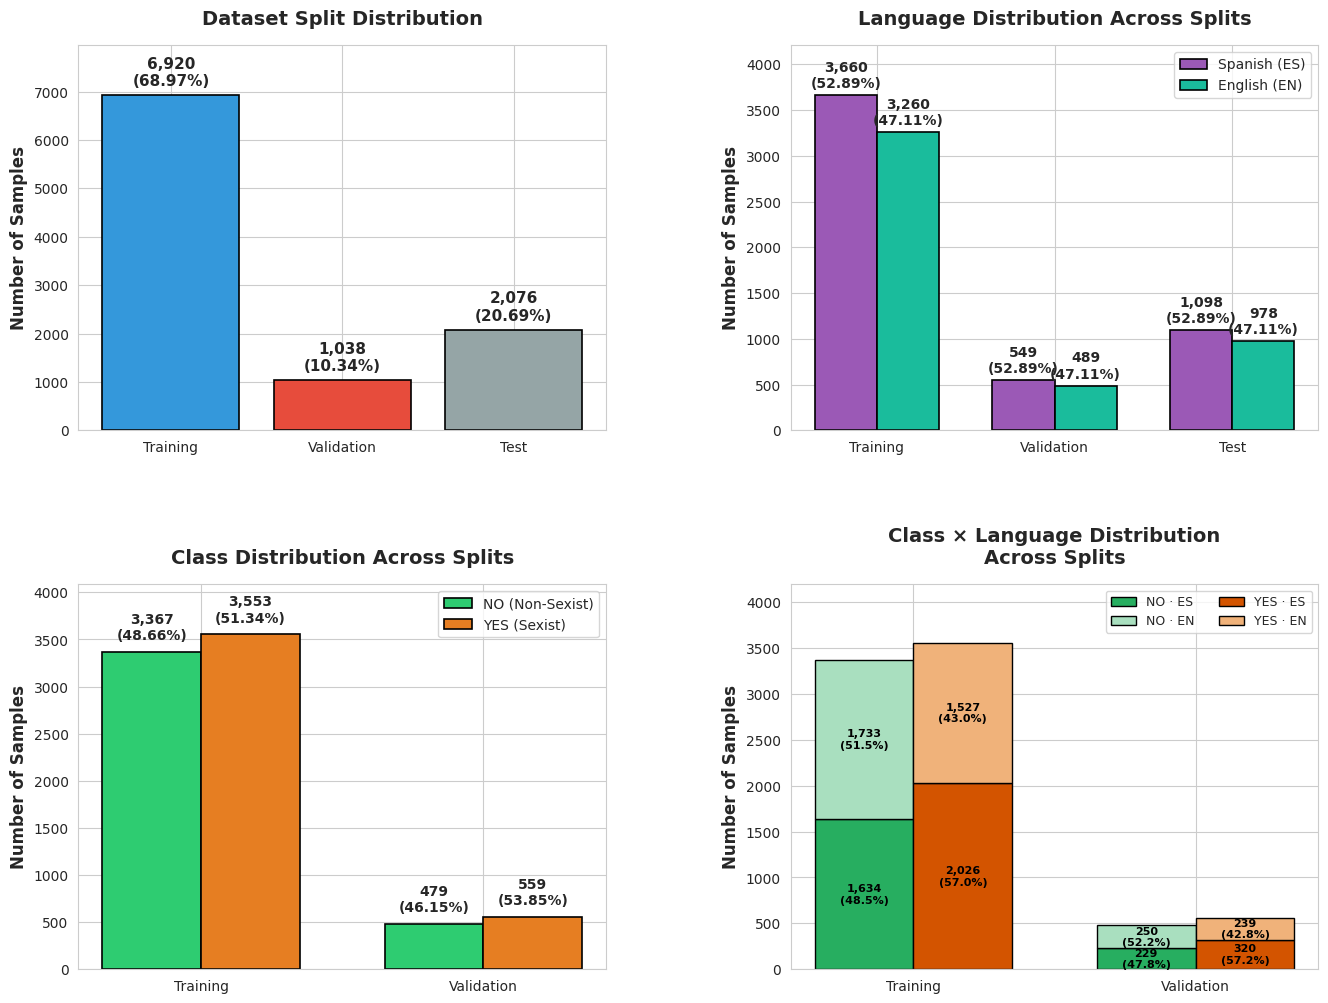

In [29]:
# ==========================================
# DATA DISTRIBUTION VISUALIZATION
# ==========================================
# Prepare data for plotting
split_names = ['Training', 'Validation', 'Test']
split_counts = [len(df_train), len(df_val), len(df_test)]
split_percentages = [count / sum(split_counts) * 100 for count in split_counts]

# Language distribution data
lang_dist_data = {
    'Training': [
        (df_train['lang'] == 'es').sum(),
        (df_train['lang'] == 'en').sum()
    ],
    'Validation': [
        (df_val['lang'] == 'es').sum(),
        (df_val['lang'] == 'en').sum()
    ],
    'Test': [
        (df_test['lang'] == 'es').sum(),
        (df_test['lang'] == 'en').sum()
    ]
}

# Class distribution data
class_dist_data = {
    'Training': [
        (df_train['final_label_str'] == 'NO').sum(),
        (df_train['final_label_str'] == 'YES').sum()
    ],
    'Validation': [
        (df_val['final_label_str'] == 'NO').sum(),
        (df_val['final_label_str'] == 'YES').sum()
    ],
    'Test': [0, 0]  # No labels
}

# Class x Language distribution data (labeled splits only)
dfs = {'Training': df_train, 'Validation': df_val}
class_lang_dist_data = {
    split: {
        'NO_es':  ((df['final_label_str'] == 'NO')  & (df['lang'] == 'es')).sum(),
        'NO_en':  ((df['final_label_str'] == 'NO')  & (df['lang'] == 'en')).sum(),
        'YES_es': ((df['final_label_str'] == 'YES') & (df['lang'] == 'es')).sum(),
        'YES_en': ((df['final_label_str'] == 'YES') & (df['lang'] == 'en')).sum(),
    }
    for split, df in dfs.items()
}

# Set style
sns.set_style("whitegrid")
fig = plt.figure(figsize=(16, 12))
gs = fig.add_gridspec(2, 2, hspace=0.4, wspace=0.35)

axes = [
    fig.add_subplot(gs[0, 0]),
    fig.add_subplot(gs[0, 1]),
    fig.add_subplot(gs[1, 0]),
    fig.add_subplot(gs[1, 1]),
]

width = 0.35

# ── Plot 1: Data Split Distribution ──────────────────────────────────────────
colors_split = ['#3498db', '#e74c3c', '#95a5a6']
bars1 = axes[0].bar(split_names, split_counts, color=colors_split, edgecolor='black', linewidth=1.2)
axes[0].set_ylabel('Number of Samples', fontsize=12, fontweight='bold')
axes[0].set_title('Dataset Split Distribution', fontsize=14, fontweight='bold', pad=15)
axes[0].set_ylim(0, max(split_counts) * 1.15)

for bar, count, pct in zip(bars1, split_counts, split_percentages):
    height = bar.get_height()
    axes[0].text(bar.get_x() + bar.get_width()/2., height + max(split_counts)*0.02,
                f'{count:,}\n({pct:.2f}%)',
                ha='center', va='bottom', fontsize=11, fontweight='bold')

# ── Plot 2: Language Distribution by Split ────────────────────────────────────
x = np.arange(len(split_names))
colors_lang = ['#9b59b6', '#1abc9c']

bars_es = axes[1].bar(x - width/2, [lang_dist_data[split][0] for split in split_names],
                       width, label='Spanish (ES)', color=colors_lang[0], edgecolor='black', linewidth=1.2)
bars_en = axes[1].bar(x + width/2, [lang_dist_data[split][1] for split in split_names],
                       width, label='English (EN)', color=colors_lang[1], edgecolor='black', linewidth=1.2)

axes[1].set_ylabel('Number of Samples', fontsize=12, fontweight='bold')
axes[1].set_title('Language Distribution Across Splits', fontsize=14, fontweight='bold', pad=15)
axes[1].set_xticks(x)
axes[1].set_xticklabels(split_names)
axes[1].legend(fontsize=10, loc='upper right')
axes[1].set_ylim(0, max([max(lang_dist_data[split]) for split in split_names]) * 1.15)

for i, split in enumerate(split_names):
    total = sum(lang_dist_data[split])
    height_es = bars_es[i].get_height()
    if height_es > 0:
        pct_es = (height_es / total * 100) if total > 0 else 0
        axes[1].text(bars_es[i].get_x() + bars_es[i].get_width()/2., height_es + 50,
                    f'{int(height_es):,}\n({pct_es:.2f}%)',
                    ha='center', va='bottom', fontsize=10, fontweight='bold')
    height_en = bars_en[i].get_height()
    if height_en > 0:
        pct_en = (height_en / total * 100) if total > 0 else 0
        axes[1].text(bars_en[i].get_x() + bars_en[i].get_width()/2., height_en + 50,
                    f'{int(height_en):,}\n({pct_en:.2f}%)',
                    ha='center', va='bottom', fontsize=10, fontweight='bold')

# ── Plot 3: Class Distribution by Split ──────────────────────────────────────
split_names_labeled = split_names[:-1]
x = np.arange(len(split_names_labeled))
colors_class = ['#2ecc71', '#e67e22']

bars_no = axes[2].bar(x - width/2, [class_dist_data[split][0] for split in split_names_labeled],
                       width, label='NO (Non-Sexist)', color=colors_class[0], edgecolor='black', linewidth=1.2)
bars_yes = axes[2].bar(x + width/2, [class_dist_data[split][1] for split in split_names_labeled],
                        width, label='YES (Sexist)', color=colors_class[1], edgecolor='black', linewidth=1.2)

axes[2].set_ylabel('Number of Samples', fontsize=12, fontweight='bold')
axes[2].set_title('Class Distribution Across Splits', fontsize=14, fontweight='bold', pad=15)
axes[2].set_xticks(x)
axes[2].set_xticklabels(split_names_labeled)
axes[2].legend(fontsize=10, loc='upper right')
axes[2].set_ylim(0, max([max(class_dist_data[split]) for split in split_names_labeled]) * 1.15)

for i, split in enumerate(split_names_labeled):
    total = sum(class_dist_data[split])
    height_no = bars_no[i].get_height()
    if height_no > 0:
        pct_no = (height_no / total * 100) if total > 0 else 0
        axes[2].text(bars_no[i].get_x() + bars_no[i].get_width()/2., height_no + 100,
                    f'{int(height_no):,}\n({pct_no:.2f}%)',
                    ha='center', va='bottom', fontsize=10, fontweight='bold')
    height_yes = bars_yes[i].get_height()
    if height_yes > 0:
        pct_yes = (height_yes / total * 100) if total > 0 else 0
        axes[2].text(bars_yes[i].get_x() + bars_yes[i].get_width()/2., height_yes + 100,
                    f'{int(height_yes):,}\n({pct_yes:.2f}%)',
                    ha='center', va='bottom', fontsize=10, fontweight='bold')

# ── Plot 4: Class × Language Distribution ────────────────────────────────────
x = np.arange(len(split_names_labeled))

no_es_vals  = [class_lang_dist_data[s]['NO_es']  for s in split_names_labeled]
no_en_vals  = [class_lang_dist_data[s]['NO_en']  for s in split_names_labeled]
yes_es_vals = [class_lang_dist_data[s]['YES_es'] for s in split_names_labeled]
yes_en_vals = [class_lang_dist_data[s]['YES_en'] for s in split_names_labeled]

c_no_es  = '#27ae60'
c_no_en  = '#a9dfbf'
c_yes_es = '#d35400'
c_yes_en = '#f0b27a'

bars_no_es  = axes[3].bar(x - width/2, no_es_vals,  width, label='NO · ES', color=c_no_es,  edgecolor='black', linewidth=1.0)
bars_no_en  = axes[3].bar(x - width/2, no_en_vals,  width, label='NO · EN', color=c_no_en,  edgecolor='black', linewidth=1.0, bottom=no_es_vals)
bars_yes_es = axes[3].bar(x + width/2, yes_es_vals, width, label='YES · ES', color=c_yes_es, edgecolor='black', linewidth=1.0)
bars_yes_en = axes[3].bar(x + width/2, yes_en_vals, width, label='YES · EN', color=c_yes_en, edgecolor='black', linewidth=1.0, bottom=yes_es_vals)

axes[3].set_ylabel('Number of Samples', fontsize=12, fontweight='bold')
axes[3].set_title('Class × Language Distribution\nAcross Splits', fontsize=14, fontweight='bold', pad=15)
axes[3].set_xticks(x)
axes[3].set_xticklabels(split_names_labeled)
axes[3].legend(fontsize=9, loc='upper right', ncol=2)

max_stack = max(
    max(no_es_vals[i] + no_en_vals[i] for i in range(len(split_names_labeled))),
    max(yes_es_vals[i] + yes_en_vals[i] for i in range(len(split_names_labeled)))
)
axes[3].set_ylim(0, max_stack * 1.18)

for i, split in enumerate(split_names_labeled):
    total_no  = class_dist_data[split][0]
    total_yes = class_dist_data[split][1]

    for val, bottom, total, xpos in [
        (no_es_vals[i],  0,              total_no,  x[i] - width/2),
        (no_en_vals[i],  no_es_vals[i],  total_no,  x[i] - width/2),
        (yes_es_vals[i], 0,              total_yes, x[i] + width/2),
        (yes_en_vals[i], yes_es_vals[i], total_yes, x[i] + width/2),
    ]:
        if val > 0:
            pct = val / total * 100
            axes[3].text(xpos, bottom + val / 2,
                        f'{val:,}\n({pct:.1f}%)',
                        ha='center', va='center', fontsize=8, fontweight='bold', color='black')

plt.savefig('../report/figures/data_splits_and_class_distribution.pdf', dpi=80, bbox_inches='tight')
plt.show()

## 2.3 Dataset and Vocabulary Statistics

In [4]:
def compute_avg_text_length(df):
    """
    Computes the average text length (in words) of tweets in the dataframe.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame containing a 'tweet' column with text data
    
    Returns:
    --------
    float
        Average text length across all tweets
    """
    total_words = 0
    total_tweets = 0
    
    for tweet in df['tweet']:
        if isinstance(tweet, str):
            words = tweet.split()
            total_words += len(words)
            total_tweets += 1
    
    if total_tweets == 0:
        return 0.0
    
    return total_words / total_tweets

# Usage examples:
avg_text_len_train = compute_avg_text_length(df_train)
avg_text_len_val = compute_avg_text_length(df_val)
avg_text_len_test = compute_avg_text_length(df_test)

print(f"Average text length (words) - Training: {avg_text_len_train:.2f}")
print(f"Average text length (words) - Validation: {avg_text_len_val:.2f}")
print(f"Average text length (words) - Test: {avg_text_len_test:.2f}")

Average text length (words) - Training: 28.14
Average text length (words) - Validation: 28.58
Average text length (words) - Test: 27.87


# 3. Ablation Studies

## 3.1 Preprocessing Ablation Study

In [44]:
cv_results['estimator']

[Pipeline(steps=[('vect', TfidfVectorizer(lowercase=False)),
                 ('clf', LogisticRegression(max_iter=2000, random_state=42))]),
 Pipeline(steps=[('vect', TfidfVectorizer(lowercase=False)),
                 ('clf', LogisticRegression(max_iter=2000, random_state=42))]),
 Pipeline(steps=[('vect', TfidfVectorizer(lowercase=False)),
                 ('clf', LogisticRegression(max_iter=2000, random_state=42))]),
 Pipeline(steps=[('vect', TfidfVectorizer(lowercase=False)),
                 ('clf', LogisticRegression(max_iter=2000, random_state=42))]),
 Pipeline(steps=[('vect', TfidfVectorizer(lowercase=False)),
                 ('clf', LogisticRegression(max_iter=2000, random_state=42))])]

In [45]:
from sklearn.model_selection import cross_validate

# ==========================================
# 2. PREPROCESSING ABLATION STUDY (Section 4.2)
# ==========================================
print("\n--- 4.2 PREPROCESSING ABLATION STUDY ---")

stop_words = set(stopwords.words('english')) | set(stopwords.words('spanish'))
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

def preprocess_text(text, strategy='raw'):
    """
    Implements the specific strategies defined in Section 4.2.1
    """
    text_processed = str(text)
    
    if strategy == 'raw':
        return text_processed
        
    if strategy == 'lowercase':
        return text_processed.lower()
        
    if strategy == 'no_punct':
        # Remove punctuation, keep spaces
        text_processed = re.sub(r'[^\w\s]', '', text_processed)
        return text_processed.lower()
        
    if strategy == 'no_stopwords':
        text_processed = text_processed.lower()
        words = text_processed.split()
        return " ".join([w for w in words if w not in stop_words])
        
    if strategy == 'stemmed':
        text_processed = text_processed.lower()
        words = text_processed.split()
        return " ".join([stemmer.stem(w) for w in words])
        
    if strategy == 'lemmatized':
        text_processed = text_processed.lower()
        # Simple tokenization for lemmatizer
        words = text_processed.split() 
        return " ".join([lemmatizer.lemmatize(w) for w in words])
        
    return text_processed

# We need to split data FIRST to avoid data leakage (Section 3.1)
# Using 'raw' text as the base source
X_train_raw = df_train['tweet']
y_train = df_train['label']

X_val_raw = df_val['tweet']
y_val = df_val['label']

X_test_raw = df_test['tweet']

strategies = ['raw', 'lowercase', 'no_punct', 'no_stopwords', 'stemmed', 'lemmatized']
results = []

for strat in strategies:
    print(f"Testing strategy: {strat}...")
    
    prep_start_time = time()
    X_train_curr = [preprocess_text(text, strat) for text in X_train_raw]
    prep_end_time = time()
    prep_time = prep_end_time - prep_start_time
    
    pipe = Pipeline([
        ('vect', TfidfVectorizer(lowercase=False)), 
        ('clf', LogisticRegression(max_iter=2000, random_state=42))
    ])
    
    cv_results = cross_validate(
        pipe, X_train_curr, y_train, 
        cv=5, 
        scoring='f1_macro', 
        return_estimator=True, 
        n_jobs=-1
    )
    
    mean_score = cv_results['test_score'].mean()
    mean_fit_time = cv_results['fit_time'].mean()

    vocab_sizes = [len(m.named_steps['vect'].vocabulary_) for m in cv_results['estimator']]
    mean_vocab_len = np.mean(vocab_sizes)
    
    print(f"Avg. Vocab-Size: {mean_vocab_len} | Preprocess-Time: {prep_time:.3f} s | Avg. Fit-Time: {mean_fit_time:.3f} s | F1-Score: {mean_score:.4f}\n")


--- 4.2 PREPROCESSING ABLATION STUDY ---
Testing strategy: raw...
Avg. Vocab-Size: 35126.0 | Preprocess-Time: 0.002 s | Avg. Fit-Time: 0.315 s | F1-Score: 0.6455

Testing strategy: lowercase...
Avg. Vocab-Size: 31351.4 | Preprocess-Time: 0.008 s | Avg. Fit-Time: 0.279 s | F1-Score: 0.6506

Testing strategy: no_punct...
Avg. Vocab-Size: 32350.8 | Preprocess-Time: 0.041 s | Avg. Fit-Time: 0.278 s | F1-Score: 0.6449

Testing strategy: no_stopwords...
Avg. Vocab-Size: 31257.4 | Preprocess-Time: 0.043 s | Avg. Fit-Time: 0.316 s | F1-Score: 0.6496

Testing strategy: stemmed...
Avg. Vocab-Size: 29547.6 | Preprocess-Time: 1.345 s | Avg. Fit-Time: 0.233 s | F1-Score: 0.6493

Testing strategy: lemmatized...
Avg. Vocab-Size: 30829.4 | Preprocess-Time: 0.481 s | Avg. Fit-Time: 0.249 s | F1-Score: 0.6472



In [40]:
# Prepare Data with Best Strategy
X_train = [preprocess_text(t, 'lowercase') for t in X_train_raw]
X_val = [preprocess_text(t, 'lowercase') for t in X_val_raw]
X_test = [preprocess_text(t, 'lowercase') for t in X_test_raw]

## 3.2 N-Gram Ablation Study

In [32]:
df_results.columns

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_vect__ngram_range', 'params', 'split0_test_score',
       'split1_test_score', 'split2_test_score', 'split3_test_score',
       'split4_test_score', 'mean_test_score', 'std_test_score',
       'rank_test_score'],
      dtype='object')

In [41]:
# ==========================================
# 3. N-GRAM EXPLORATION (Section 4.1)
# ==========================================
print("\n--- 4.1 N-GRAM EXPLORATION ---")

def get_vocab_size(ngram_range):
    v = TfidfVectorizer(ngram_range=ngram_range, lowercase=False)
    v.fit(X_train) 
    return len(v.vocabulary_)
    
pipe = Pipeline([
    ('vect', TfidfVectorizer(lowercase=False)), 
    ('clf', LogisticRegression(max_iter=2000, random_state=42))
])

ngram_grid = {
    'vect__ngram_range': [(1, 1), (1, 2), (1, 3), (2, 2), (2, 3), (3, 3)]
}

cv_results = cross_validate(
    pipe, X_train, y_train, 
    cv=5, 
    scoring='f1_macro', 
    return_estimator=True, 
    n_jobs=-1
)

ngram_grid = GridSearchCV(pipe, ngram_grid, cv=5, scoring='f1_macro', n_jobs=4, verbose=1, refit = False)
ngram_grid.fit(X_train, y_train)

df_results = pd.DataFrame(ngram_grid.cv_results_)

df_results['vocab_size'] = df_results['param_vect__ngram_range'].apply(get_vocab_size)

final_report = df_results[[
    'param_vect__ngram_range', 
    'mean_test_score', 
    'mean_fit_time', 
    'vocab_size'
]].sort_values(by='mean_test_score', ascending=False)

print(final_report)


--- 4.1 N-GRAM EXPLORATION ---
Fitting 5 folds for each of 6 candidates, totalling 30 fits
  param_vect__ngram_range  mean_test_score  mean_fit_time  vocab_size
0                  (1, 1)         0.650561       0.262985       37033
1                  (1, 2)         0.627650       1.021148      160808
2                  (1, 3)         0.612375       2.083258      324747
3                  (2, 2)         0.559672       0.870925      123775
4                  (2, 3)         0.554547       2.188011      287714
5                  (3, 3)         0.457361       0.849792      163939


# 4. Sparse Hyperparameter Optimization

In [ ]:
# ==========================================
# 1. DEFINE PIPELINES AND PARAMETERS
# ==========================================

# --- CONFIGURATION A: LOGISTIC REGRESSION ---
pipe_lr = Pipeline([
    ('vect', TfidfVectorizer(lowercase = False, ngram_range = (1, 1))),
    ('clf', LogisticRegression(max_iter=2000, random_state=42))
])

param_grid_lr = {
    # TF-IDF Params (Your new hyperparameters)
    'vect__min_df': [1, 2, 5],         # 1=Keep all, 2=Remove unique words (noise)
    'vect__binary': [True, False],  # Does frequency matter or just presence?
    'vect__sublinear_tf': [True, False], # Logarithmic smoothing (log(1+tf))
    'vect__max_features': [10000, 20000, 40000], 
    
    # LR Params
    'clf__C': [0.1, 1, 10],
    'clf__class_weight': [None, 'balanced']
}

# --- CONFIGURATION B: SVM (LinearSVC) ---
pipe_svm = Pipeline([
    ('vect', TfidfVectorizer(lowercase = False, ngram_range = (1, 1))),
    ('clf', LinearSVC(random_state=42, dual='auto'))
])

param_grid_svm = {
    'vect__min_df': [1, 2, 5],
    'vect__binary': [True, False],
    'vect__sublinear_tf': [True, False],
    'vect__max_features': [10000, 20000, 40000], 
    
    # SVM Params
    'clf__C': [0.1, 1, 10],
    'clf__class_weight': [None, 'balanced']
}

# ==========================================
# 2. EXECUTE GRID SEARCH (WITH YOUR FIXED SPLIT)
# ==========================================

# NOTE: We pass cv=pds to force using your X_val as the only validation set
print("\n--- Searching for best hyperparameters (Logistic Regression) ---")
grid_lr = GridSearchCV(pipe_lr, param_grid_lr, cv=5, scoring='f1_macro', n_jobs=4, verbose=1, refit = True)
grid_lr.fit(X_train, y_train) 
print("\n", "=" * 60, "\n")

print("\n--- Searching for best hyperparameters (SVM - LinearSVC) ---")
grid_svm = GridSearchCV(pipe_svm, param_grid_svm, cv=5, scoring='f1_macro', n_jobs=4, verbose=1, refit = True)
grid_svm.fit(X_train, y_train)
print("\n", "=" * 60, "\n")

print(f"Best LR F1: {grid_lr.best_score_:.4f}")
print(f"Best LR Params: {grid_lr.best_params_}")
print()
print(f"Best SVM F1: {grid_svm.best_score_:.4f}")
print(f"Best SVM Params: {grid_svm.best_params_}")


--- Searching for best hyperparameters (Logistic Regression) ---
Fitting 5 folds for each of 216 candidates, totalling 1080 fits


In [ ]:
df_lr = pd.DataFrame(grid_lr.cv_results_)
df_lr['Model'] = 'Logistic Regression'

df_svm = pd.DataFrame(grid_svm.cv_results_)
df_svm['Model'] = 'SVM (LinearSVC)'

df_all = pd.concat([df_lr, df_svm])
df_all['param_vect__max_features'] = df_all['param_vect__max_features'].fillna('None')

subset = df_all[
    (df_all['param_vect__binary'] == True) &
    (df_all['param_vect__max_features'] == 40000) &
    (df_all['param_vect__min_df'] == 1) &
    (df_all['param_vect__sublinear_tf'] == True) &
    (df_all['param_clf__class_weight'] == 'balanced')
]

plt.figure(figsize=(10, 6))

sns.lineplot(
    data=subset,
    x='param_clf__C',
    y='mean_test_score',
    hue='Model',
    markers=True,
    dashes=False,
    palette={'Logistic Regression': 'blue', 'SVM (LinearSVC)': 'red'}
)

plt.xscale('log')
plt.title('Comparation: SVM vs Logistic Regression\n(Fixed: N-gram=(1,1), Binary=True, MaxFeat=None, MinDF=1)')
plt.xlabel('Regularization C (Log Scale)')
plt.ylabel('F1 Macro Score')
plt.legend(title='Modelo', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, which="both", ls="-", alpha=0.5)
plt.tight_layout()
plt.show()

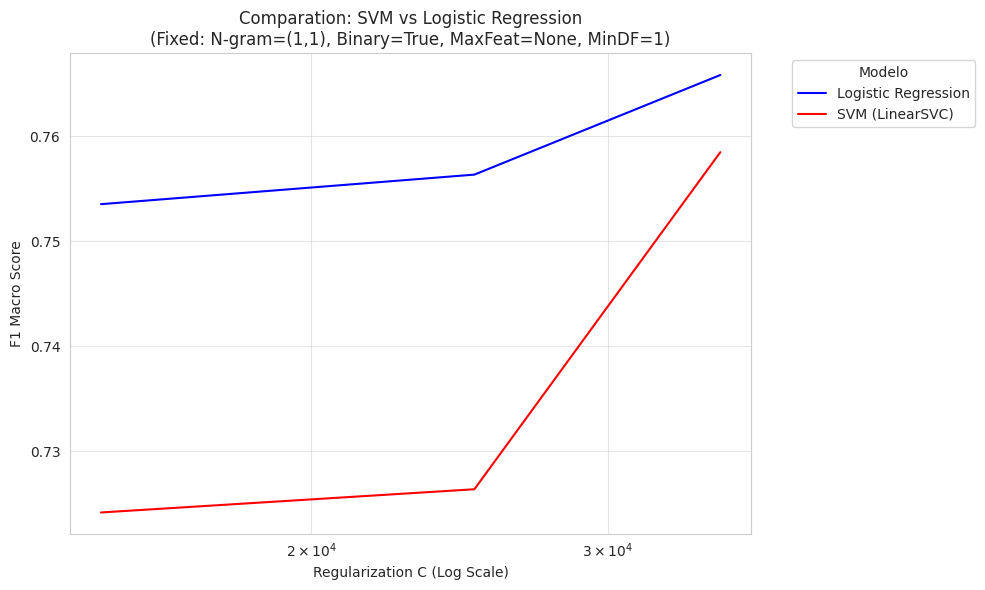


[CV 1/1] END clf__C=10, clf__class_weight=None, vect__binary=False, vect__max_features=25000, vect__min_df=5, vect__sublinear_tf=False;, score=0.717 total time=   0.6s
[CV 1/1] END clf__C=10, clf__class_weight=None, vect__binary=False, vect__max_features=35000, vect__min_df=2, vect__sublinear_tf=False;, score=0.715 total time=   0.6s
[CV 1/1] END clf__C=10, clf__class_weight=balanced, vect__binary=True, vect__max_features=15000, vect__min_df=2, vect__sublinear_tf=False;, score=0.714 total time=   0.7s
[CV 1/1] END clf__C=10, clf__class_weight=balanced, vect__binary=True, vect__max_features=25000, vect__min_df=2, vect__sublinear_tf=True;, score=0.714 total time=   0.5s
[CV 1/1] END clf__C=10, clf__class_weight=balanced, vect__binary=True, vect__max_features=25000, vect__min_df=5, vect__sublinear_tf=True;, score=0.707 total time=   0.3s
[CV 1/1] END clf__C=10, clf__class_weight=balanced, vect__binary=True, vect__max_features=35000, vect__min_df=2, vect__sublinear_tf=True;, score=0.714 t

In [23]:
df_lr = pd.DataFrame(grid_lr.cv_results_)
df_lr['Model'] = 'Logistic Regression'

df_svm = pd.DataFrame(grid_svm.cv_results_)
df_svm['Model'] = 'SVM (LinearSVC)'

df_all = pd.concat([df_lr, df_svm])
df_all['param_vect__max_features'] = df_all['param_vect__max_features'].fillna('None')

subset = df_all[
    (df_all['param_vect__binary'] == True) &
    (df_all['param_clf__C'] == 10) &
    (df_all['param_vect__min_df'] == 1) &
    (df_all['param_vect__sublinear_tf'] == True) &
    (df_all['param_clf__class_weight'] == 'balanced')
]

plt.figure(figsize=(10, 6))

sns.lineplot(
    data=subset,
    x='param_vect__max_features',
    y='mean_test_score',
    hue='Model',
    markers=True,
    dashes=False,
    palette={'Logistic Regression': 'blue', 'SVM (LinearSVC)': 'red'}
)

plt.xscale('log')
plt.title('Comparation: SVM vs Logistic Regression\n(Fixed: N-gram=(1,1), Binary=True, MaxFeat=None, MinDF=1)')
plt.xlabel('Regularization C (Log Scale)')
plt.ylabel('F1 Macro Score')
plt.legend(title='Modelo', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, which="both", ls="-", alpha=0.5)
plt.tight_layout()
plt.show()

In [59]:
def generate_submission_json(ids, preds, filename="submission_EXIST2025.json"):

    label_map = {0: 'NO', 1: 'YES'}
    submission_list = []

    for id_tweet, pred in zip(ids, preds):
        # submission_dict[str(id_tweet)] = label_map[prediccion]
        submission_list.append(
            {
                "test_case": "EXIST2025",
                "id": str(id_tweet),
                "value": label_map[pred]
            }
        )
    try:
        with open(filename, 'w', encoding='utf-8') as f:
            json.dump(submission_list, f, indent=4)
        
    except Exception as e:
        print(f"Error: {e}")

sparse_model = grid_lr.best_estimator_
sparse_test_preds = sparse_model.predict(X_test)
test_ids = df_test['id_EXIST'].values

generate_submission_json(test_ids, sparse_test_preds, "../results/submissions/sparse_preds.json")

# 5. Dense (FastText) Optimization

In [24]:
import pandas as pd
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, PredefinedSplit
from gensim.models import FastText

# ==========================================
# 1. PREPARE THE "PREDEFINED SPLIT"
# ==========================================
# Combine data just like we did for the Sparse case
# X_train and X_val are lists -> Use '+'
X_combined = X_train + X_val 

# y_train and y_val are Series -> Use pd.concat
y_combined = pd.concat([y_train, y_val])

# Create the index: -1 for Train, 0 for Validation
split_index = [-1]*len(X_train) + [0]*len(X_val)
pds = PredefinedSplit(test_fold=split_index)

print(f"Combined Data for FastText: {len(X_combined)} samples.")
print(f"Training: {len(X_train)} | Validation: {len(X_val)}")

# ==========================================
# 2. DEFINE VECTORIZER CLASS & PIPELINE
# ==========================================

class MeanEmbeddingVectorizer(BaseEstimator, TransformerMixin):
    def __init__(self, vector_size=100, window=5, min_count=1):
        self.vector_size = vector_size
        self.window = window
        self.min_count = min_count
        self.model = None

    def fit(self, X, y=None):
        sentences = [row.split() for row in X]
        # Train FastText
        self.model = FastText(sentences, 
                              vector_size=self.vector_size, 
                              window=self.window, 
                              min_count=self.min_count, 
                              workers=4, 
                              seed=42)
        return self

    def transform(self, X):
        # Note: FastText can infer vectors for OOV (Out-Of-Vocabulary) words.
        # If the word is in the vocabulary (self.model.wv), we use it.
        # If not, FastText usually calculates it via n-grams. 
        # Here we use safe logic to avoid errors if the model is not ready.
        return np.array([
            np.mean([self.model.wv[w] for w in words if w in self.model.wv]
                    or [np.zeros(self.vector_size)], axis=0)
            for words in [row.split() for row in X]
        ])

# --- CONFIGURATION A: LOGISTIC REGRESSION ---
pipe_dense_lr = Pipeline([
    ('vect', MeanEmbeddingVectorizer()),
    ('clf', LogisticRegression(max_iter=2000, random_state=42))
])

param_grid_dense_lr = {
    'vect__vector_size': [100, 300],   # Vector Dimensions
    'vect__window': [3, 5],            # Context windows
    
    # LR Params
    'clf__C': [0.1, 1, 10],
    'clf__class_weight': [None, 'balanced']
}

# --- CONFIGURATION B: SVM (LinearSVC) ---
pipe_dense_svm = Pipeline([
    ('vect', MeanEmbeddingVectorizer()),
    ('clf', LinearSVC(random_state=42, dual='auto'))
])

param_grid_dense_svm = {
    'vect__vector_size': [100, 300],   # Vector Dimensions
    'vect__window': [3, 5],            # Context windows
    
    # SVM Params
    'clf__C': [0.1, 1, 10],
    'clf__class_weight': [None, 'balanced']
}

# ==========================================
# 3. EXECUTE GRID SEARCH (WITH YOUR FIXED SPLIT)
# ==========================================

# NOTE: We pass cv=pds to force using your X_val as the only validation set
print("\n--- Searching for best hyperparameters (Logistic Regression) ---")
grid_dense_lr = GridSearchCV(pipe_dense_lr, param_grid_dense_lr, cv=pds, scoring='f1_macro', n_jobs=4, verbose=3, refit = True)
grid_dense_lr.fit(X_combined, y_combined) # We pass EVERYTHING, it knows what to split thanks to 'pds'
print("=" * 60, "\n")

print("\n--- Searching for best hyperparameters (SVM - LinearSVC) ---")
grid_dense_svm = GridSearchCV(pipe_dense_svm, param_grid_dense_svm, cv=pds, scoring='f1_macro', n_jobs=4, verbose=3, refit = True)
grid_dense_svm.fit(X_combined, y_combined)
print("=" * 60, "\n")

print(f"Best LR F1: {grid_dense_lr.best_score_:.4f}")
print(f"Best LR Params: {grid_dense_lr.best_params_}")
print()
print(f"Best SVM F1: {grid_dense_svm.best_score_:.4f}")
print(f"Best SVM Params: {grid_dense_svm.best_params_}")

Combined Data for FastText: 7958 samples.
Training: 6920 | Validation: 1038

--- Searching for best hyperparameters (Logistic Regression) ---
Fitting 1 folds for each of 24 candidates, totalling 24 fits


--- Searching for best hyperparameters (SVM - LinearSVC) ---
Fitting 1 folds for each of 24 candidates, totalling 24 fits

Best LR F1: 0.6122
Best LR Params: {'clf__C': 10, 'clf__class_weight': None, 'vect__vector_size': 100, 'vect__window': 5}

Best SVM F1: 0.6322
Best SVM Params: {'clf__C': 10, 'clf__class_weight': None, 'vect__vector_size': 100, 'vect__window': 3}


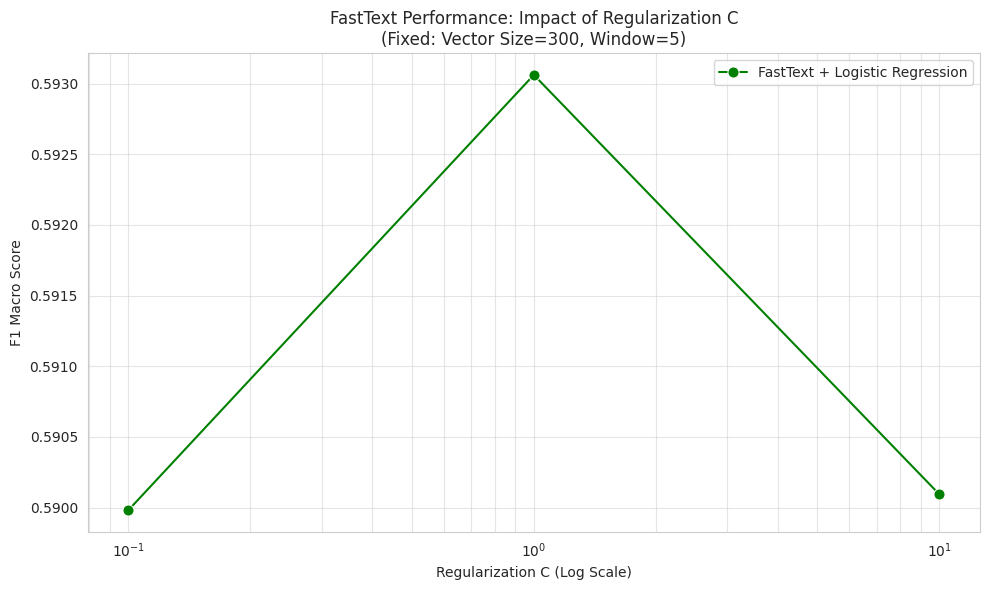

In [13]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Extraemos los resultados del GridSearch de FastText
df_fasttext = pd.DataFrame(grid_search.cv_results_)

# 2. FILTRADO: Nos quedamos solo con la mejor configuración estructural
# {'vect__vector_size': 300, 'vect__window': 5}
subset_ft = df_fasttext[
    (df_fasttext['param_vect__vector_size'] == 300) &
    (df_fasttext['param_vect__window'] == 5)
]

# 3. GRÁFICA
plt.figure(figsize=(10, 6))

sns.lineplot(
    data=subset_ft,
    x='param_clf__C',
    y='mean_test_score',
    marker='o',
    markersize=8,
    color='green',  # Usamos verde para distinguir de SVM(rojo)/LR(azul)
    label='FastText + Logistic Regression'
)

plt.xscale('log')
plt.title('FastText Performance: Impact of Regularization C\n(Fixed: Vector Size=300, Window=5)')
plt.xlabel('Regularization C (Log Scale)')
plt.ylabel('F1 Macro Score')
plt.legend(loc='best')
plt.grid(True, which="both", ls="-", alpha=0.5)
plt.tight_layout()
plt.show()

In [60]:
dense_model = grid_dense_svm.best_estimator_
dense_test_preds = dense_model.predict(X_test)
test_ids = df_test['id_EXIST'].values

generate_submission_json(test_ids, dense_test_preds, "../results/submissions/dense_preds.json")

# End of Notebook